# Palm Weevil Trap Detection - Model Evaluation

This notebook evaluates deep learning models trained to classify between Red Palm Weevil (RPW) traps and Non-RPW traps from images. We'll evaluate two models:
1. MobileNetV3 Large
2. EfficientNet B0

## Overview
- Load pre-trained models
- Process test images with the same transformations used during training
- Evaluate model performance on test data
- Compare results between models

## Imports and Device Setup

In [1]:
import os
import glob
from PIL import Image
import torch
import torch.nn as nn
from torchvision import transforms, models
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Device setup - use GPU if available
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print("Using device:", device)

Using device: mps


## Model Loading Function

This function loads our trained models from saved checkpoints. We're using two different architectures:
1. MobileNetV3 Large - a lightweight model designed for mobile devices
2. EfficientNet B0 - known for balancing accuracy and computational efficiency

For both models, we've customized the classifier head to work with our binary classification task (RPW-trap vs NRPW-trap).

In [2]:
def load_model(model_name, path, num_classes=2):
    if model_name == "mobilenet":
        model = models.mobilenet_v3_large(weights=None)
        model.classifier = nn.Sequential(
            nn.Linear(model.classifier[0].in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes),
        )
    elif model_name == "efficientnet":
        model = models.efficientnet_b0(weights=None)
        model.classifier = nn.Sequential(
            nn.Linear(model.classifier[1].in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes),
        )
    else:
        raise ValueError("Invalid model name")
    
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()
    return model.to(device)

## Image Preprocessing

We apply the same transformations that were used during model training:
1. Resize images to 224×224 (standard input size for many CNN architectures)
2. Convert to PyTorch tensors
3. Normalize using ImageNet mean and standard deviation values

In [3]:
# Image preprocessing pipeline
img_size = 224
transform = transforms.Compose(
    [
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

## Data Loading Function

This function loads test images from their respective class folders and processes them using our transformation pipeline.

In [4]:
def load_trap_images(folder_path, class_map):
    images, labels = [], []
    for class_name, label in class_map.items():
        class_folder = os.path.join(folder_path, class_name)
        img_paths = glob.glob(os.path.join(class_folder, "*.*"))
        if not img_paths:
            print(f"⚠️ Skipping {class_name} — no images found.")
            continue
        
        print(f"Found {len(img_paths)} images in class {class_name}")
        for img_path in img_paths:
            try:
                img = Image.open(img_path).convert("RGB")
                img = transform(img)
                images.append(img)
                labels.append(label)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
    
    if len(images) == 0:
        return None, None
        
    return torch.stack(images), torch.tensor(labels)

## Model Evaluation Function

This function evaluates model performance using:
1. Accuracy metric
2. Confusion matrix visualization

The confusion matrix helps us understand false positives and false negatives in our classification task.

In [5]:
def evaluate_model(model, images, labels, class_names):
    images, labels = images.to(device), labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        acc = accuracy_score(labels.cpu(), preds.cpu())
    
    print(f"\nAccuracy: {acc:.4f}")
    
    # Generate and plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(labels.cpu(), preds.cpu())
    sns.heatmap(
        cm,
        annot=True,
        xticklabels=class_names,
        yticklabels=class_names,
        fmt="d",
        cmap="Blues",
    )
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()
    
    return acc, cm

## Main Evaluation

Now we'll load the test data and evaluate both models.

In [6]:
# Class definitions
class_names = ["NRPW-trap", "RPW-trap"]
class_to_idx = {name: idx for idx, name in enumerate(class_names)}

# Load test data
test_root = "test"
print(f"Loading test images from {test_root}...")
images, labels = load_trap_images(test_root, class_to_idx)

if images is None or len(images) == 0:
    print("No images to evaluate. Please check your test data directory.")
else:
    print(f"Loaded {len(images)} test images in total.")

Loading test images from test...
⚠️ Skipping NRPW-trap — no images found.
Found 158 images in class RPW-trap
Loaded 158 test images in total.


### MobileNetV3 Evaluation

MobileNetV3 is designed to be computationally efficient while maintaining good accuracy. Let's evaluate its performance on our test set.


🔍 Loading MobileNetV3 model...
MobileNetV3 Evaluation:

Accuracy: 0.0063


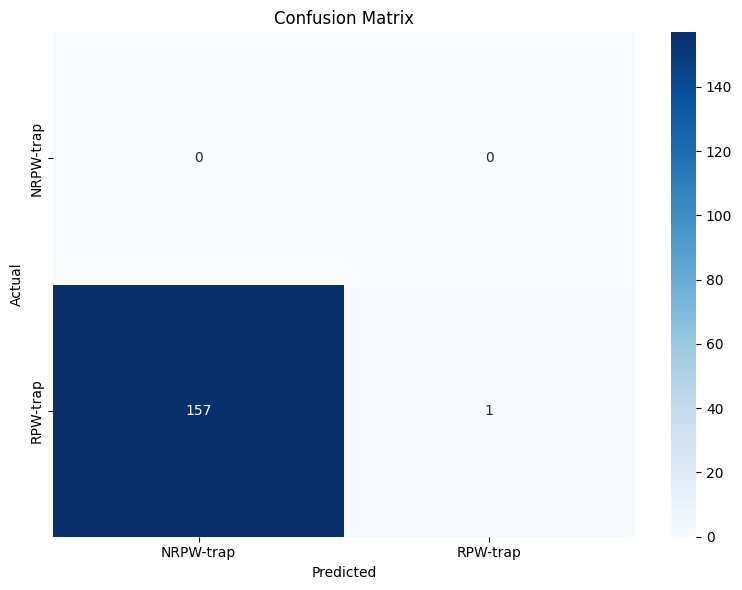

In [7]:
try:
    # Load and evaluate MobileNet
    print("\n🔍 Loading MobileNetV3 model...")
    mobilenet = load_model("mobilenet", "saved_models/mobilenetv3_rpw.pth")
    print("MobileNetV3 Evaluation:")
    mobilenet_acc, mobilenet_cm = evaluate_model(mobilenet, images, labels, class_names)
except Exception as e:
    print(f"Error evaluating MobileNetV3: {e}")

### EfficientNet Evaluation

EfficientNet is known for its scaling method that uniformly scales network width, depth, and resolution. Let's evaluate EfficientNet B0 on our test set.


🔍 Loading EfficientNetB0 model...
EfficientNetB0 Evaluation:

Accuracy: 0.0000


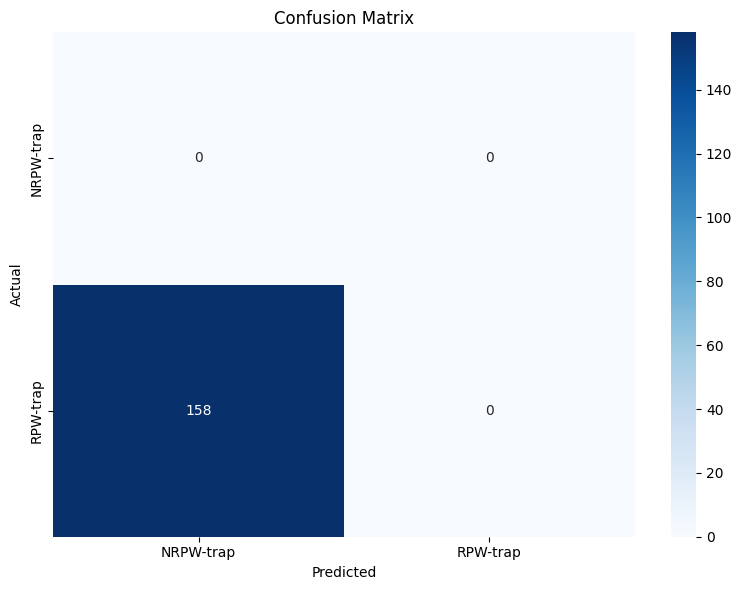

In [8]:
try:
    # Load and evaluate EfficientNet
    print("\n🔍 Loading EfficientNetB0 model...")
    efficientnet = load_model("efficientnet", "saved_models/efficientnetb0_rpw.pth")
    print("EfficientNetB0 Evaluation:")
    efficientnet_acc, efficientnet_cm = evaluate_model(efficientnet, images, labels, class_names)
except Exception as e:
    print(f"Error evaluating EfficientNetB0: {e}")

## Model Comparison

Let's compare the performance of both models side by side.

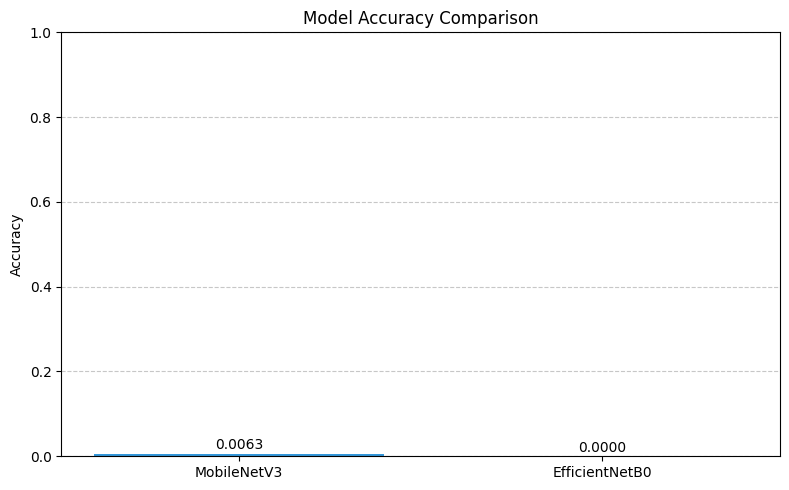


Conclusion: MobileNetV3 performed better on this test set with an accuracy of 0.0063.


In [9]:
try:
    # Compare model accuracies
    models = ["MobileNetV3", "EfficientNetB0"]
    accuracies = [mobilenet_acc, efficientnet_acc]
    
    plt.figure(figsize=(8, 5))
    plt.bar(models, accuracies, color=['#3498db', '#2ecc71'])
    plt.ylim(0, 1.0)
    plt.title('Model Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add accuracy values on top of bars
    for i, acc in enumerate(accuracies):
        plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center')
        
    plt.tight_layout()
    plt.show()
    
    # Print conclusion
    better_model = "MobileNetV3" if mobilenet_acc > efficientnet_acc else "EfficientNetB0"
    print(f"\nConclusion: {better_model} performed better on this test set with an accuracy of {max(accuracies):.4f}.")
except Exception as e:
    print(f"Error comparing models: {e}")

## Summary

In this notebook, we evaluated two deep learning models (MobileNetV3 and EfficientNetB0) on a palm weevil trap classification task. The evaluation metrics include:

1. Overall accuracy
2. Confusion matrix showing true positives, true negatives, false positives, and false negatives

### Next Steps

Based on the evaluation results, you might consider:
- Using the better-performing model for deployment
- Collecting more training data if accuracy is not satisfactory
- Trying different model architectures or hyperparameters
- Implementing ensemble methods to combine predictions from both models